In [1]:
import os
from os.path import join
import sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import cv2

PROJ_ROOT = os.pardir
data_dir = join(PROJ_ROOT, 'dataset')
train_folder = join(data_dir, 'train')
mask_folder = join(data_dir, 'train_masks')
train_imgs = os.listdir(train_folder)
mask_imgs = os.listdir(mask_folder)

model_dir = join(PROJ_ROOT, 'models')
sys.path.append(model_dir)
callback_dir = join(PROJ_ROOT, 'callbacks')
sys.path.append(callback_dir)

from unet import unet
from learning_rate import lr_schedule

np.random.seed(33)

In [2]:
print(len(train_imgs))
print(len(mask_imgs))

5088
5088


In [3]:
carvana_df = pd.read_csv(
    join(data_dir, 'train_masks.csv'), usecols=['img'])

carvana_df['img_id'] = carvana_df['img'].map(
    lambda row: row.split('.')[0])

In [4]:
def get_img_mask_arrays(img_id, input_size=256):
    # load into PIL format
    img = image.load_img(join(train_folder, '%s.jpg' % img_id),
                         target_size=(input_size, input_size))
    # convert to numpy array
    img = image.img_to_array(img)
    img = img / 255.
    mask = image.load_img(join(mask_folder, '%s_mask.gif' % img_id),
                          color_mode='grayscale', target_size=(
                              input_size, input_size))
    mask = image.img_to_array(mask)
    mask = mask / 255.
    return img, mask

def plot_img_mask(img, mask, input_size=256):
    fig, axs = plt.subplots(
        ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

(256, 256, 3) (256, 256, 1)


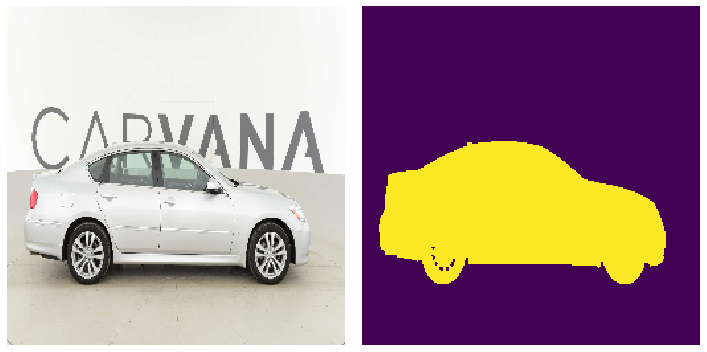

In [5]:
img_ids = carvana_df['img_id'].values
np.random.shuffle(img_ids)
img_id = img_ids[0]

img, mask = get_img_mask_arrays(img_id)
print(img.shape, mask.shape)
plot_img_mask(img, mask)

In [6]:
sample = 1200

train_img_paths = sorted(glob('../dataset/train/*.jpg'))[:sample]
train_mask_paths = sorted(glob('../dataset/train_masks/*.gif'))[:sample]

In [7]:
img_rows, img_cols = 128, 128
train_imgs = np.array([cv2.resize(plt.imread(path), (img_rows, img_cols))
                                  for path in train_img_paths])
train_masks = np.array([cv2.resize(plt.imread(path), (img_rows, img_cols))
                                  for path in train_mask_paths], dtype='float32')

In [8]:
print(train_masks.shape)
print(train_imgs.shape)

(1200, 128, 128, 4)
(1200, 128, 128, 3)


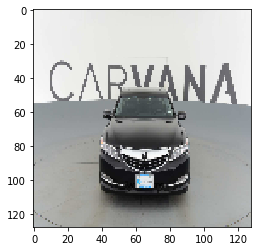

In [9]:
plt.imshow(train_imgs[0])

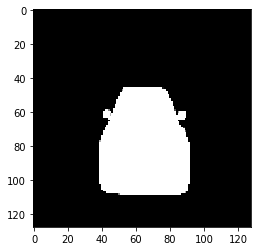

In [10]:
plt.imshow(train_masks[0] / 255.)

In [11]:
train_masks2 = []
for num, img in enumerate(train_masks):
    train_masks2.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

train_masks = np.array(train_masks2) # only thing changed

In [12]:
len(np.unique(train_masks[0]))

13

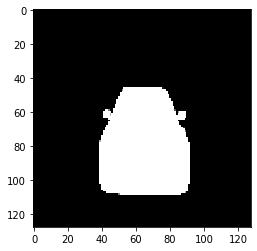

In [13]:
plt.imshow(train_masks[0], cmap='gray')

In [14]:
# train_masks2 a list, convert to array
# train_masks2 = np.array(train_masks2)

In [15]:
train_masks.shape

(1200, 128, 128)

In [16]:
train_masks[train_masks <= 127] = 0
train_masks[train_masks > 127] = 1

In [17]:
train_masks.shape

(1200, 128, 128)

In [18]:
train_masks = np.reshape(train_masks, newshape=(*train_masks.shape, 1))

In [19]:
train_masks.shape

(1200, 128, 128, 1)

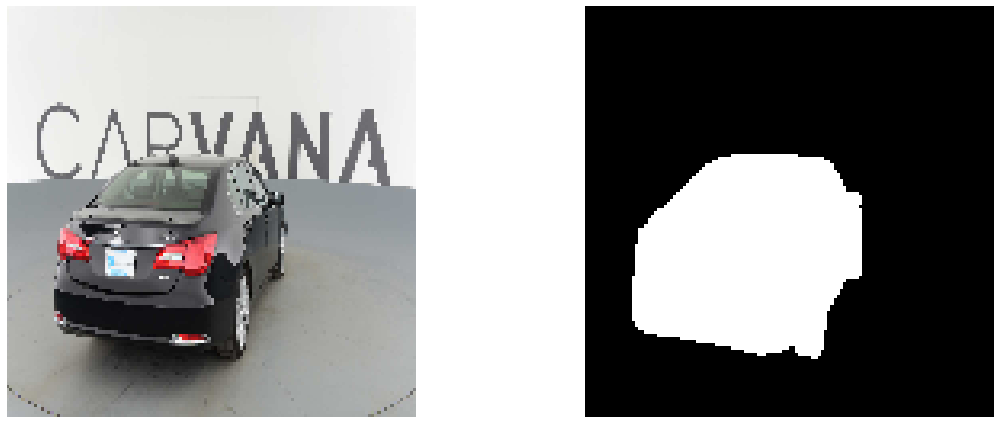

In [20]:
def plot_img_mask(img, mask, input_size=128, cmap=None):
    fig, axs = plt.subplots(
        ncols=2, figsize=(18, 6), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :], cmap=cmap)
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

plot_img_mask(train_imgs[9], np.squeeze(train_masks[9]), cmap='gray')

In [21]:
unet = unet(input_size=(128, 128, 3))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [22]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K


def dice_coeff(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f)
    d_coeff = (2.0 * intersect + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return d_coeff


def dice_loss_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    # dice_bce = 0.5 * bce(y_true, y_pred) - dice_coeff(y_true, y_pred)
    dice_bce = 1 + bce(y_true, y_pred) - dice_coeff(y_true, y_pred)
    return dice_bce

In [23]:
unet.compile(Adam(), loss=[dice_loss_bce], metrics=[dice_coeff])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.0005, 
                                                  patience=10)

In [24]:
history = unet.fit(train_imgs[100:], train_masks[100:],
                   batch_size=16, epochs=30, callbacks=[lr_callback, early_stopping],
                   validation_data=[train_imgs[25:100], train_masks[25:100]])

Train on 1100 samples, validate on 75 samples
Epoch 1/30
1100/1100 [==============================] - 115s 104ms/sample - loss: 0.8945 - dice_coeff: 0.5495 - val_loss: 1.0635 - val_dice_coeff: 0.4670
Epoch 2/30
1100/1100 [==============================] - 112s 102ms/sample - loss: 0.3405 - dice_coeff: 0.7997 - val_loss: 0.4671 - val_dice_coeff: 0.7261
Epoch 3/30
1100/1100 [==============================] - 114s 103ms/sample - loss: 0.1960 - dice_coeff: 0.8813 - val_loss: 0.1803 - val_dice_coeff: 0.8864
Epoch 4/30
1100/1100 [==============================] - 115s 104ms/sample - loss: 0.1508 - dice_coeff: 0.9074 - val_loss: 0.1098 - val_dice_coeff: 0.9337
Epoch 5/30
1100/1100 [==============================] - 115s 105ms/sample - loss: 0.1242 - dice_coeff: 0.9235 - val_loss: 0.0926 - val_dice_coeff: 0.9486
Epoch 6/30
1100/1100 [==============================] - 115s 104ms/sample - loss: 0.1069 - dice_coeff: 0.9342 - val_loss: 0.0721 - val_dice_coeff: 0.9608
Epoch 7/30
1100/1100 [========

In [25]:
def plot_losses(history):
    fix, ax = plt.subplots(2, 1, figsize=(8, 10))
    ax[0].plot(history['loss'], color='y', label='Training Loss')
    ax[0].plot(history['val_loss'], color='b', label='Val Loss')
    legend = ax[0].legend(loc='best', shadow=True)
    ax[1].plot(history['dice_coeff'], color='y', label='Training Dice')
    ax[1].plot(history['val_dice_coeff'], color='b', label='Val Dice')
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

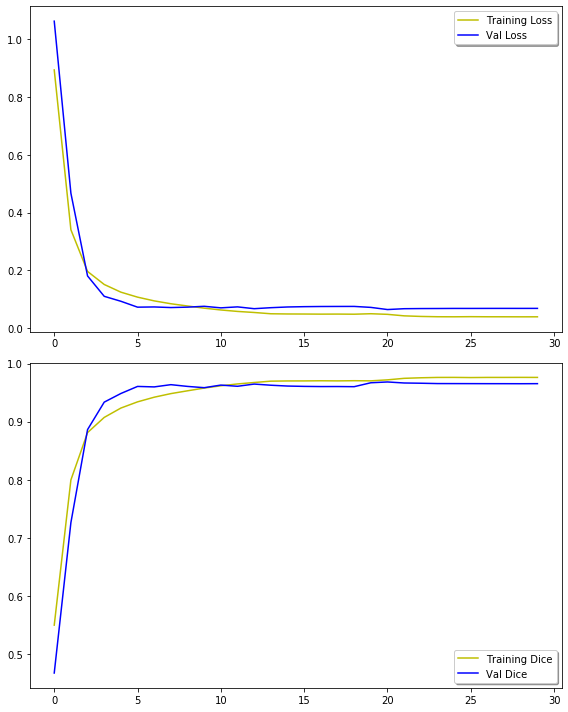

In [26]:
plot_losses(history.history)

In [27]:
test_imgs = train_imgs[:25]
test_imgs = test_imgs.astype('float16')

pred_masks = unet.predict(test_imgs[:10])

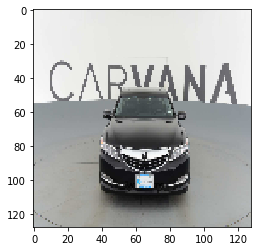

In [35]:
plt.imshow(test_imgs[0].astype(np.float32) /255.)

In [36]:
test_masks = train_masks[:25]

(25, 128, 128, 1)
float32


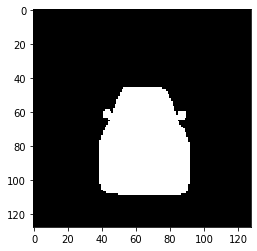

In [39]:
plt.imshow(np.squeeze(test_masks[0]), cmap='gray')

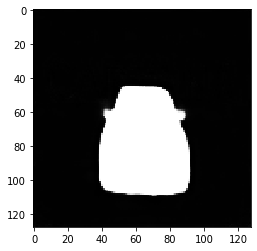

In [42]:
plt.imshow(np.squeeze(pred_masks[0]), cmap='gray')

In [43]:
def make_inference(test_imgs, test_masks, predictions, num_samples):
    fig, ax = plt.subplots(num_samples, 3, figsize=(18, 6*num_samples))
    for i in range(num_samples):
        ax[i, 0].imshow(test_imgs[i].astype(np.float32) / 255.)
        ax[i, 0].axis('off')
        ax[i, 0].title.set_text('Carvana Car')
        
        ax[i, 1].imshow(np.squeeze(test_masks[i]), cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].title.set_text('True Mask')
        
        ax[i, 2].imshow(np.squeeze(predictions[i]), cmap='gray')
        ax[i, 2].axis('off')
        ax[i, 2].title.set_text('Predicted Mask')
        
    plt.show()

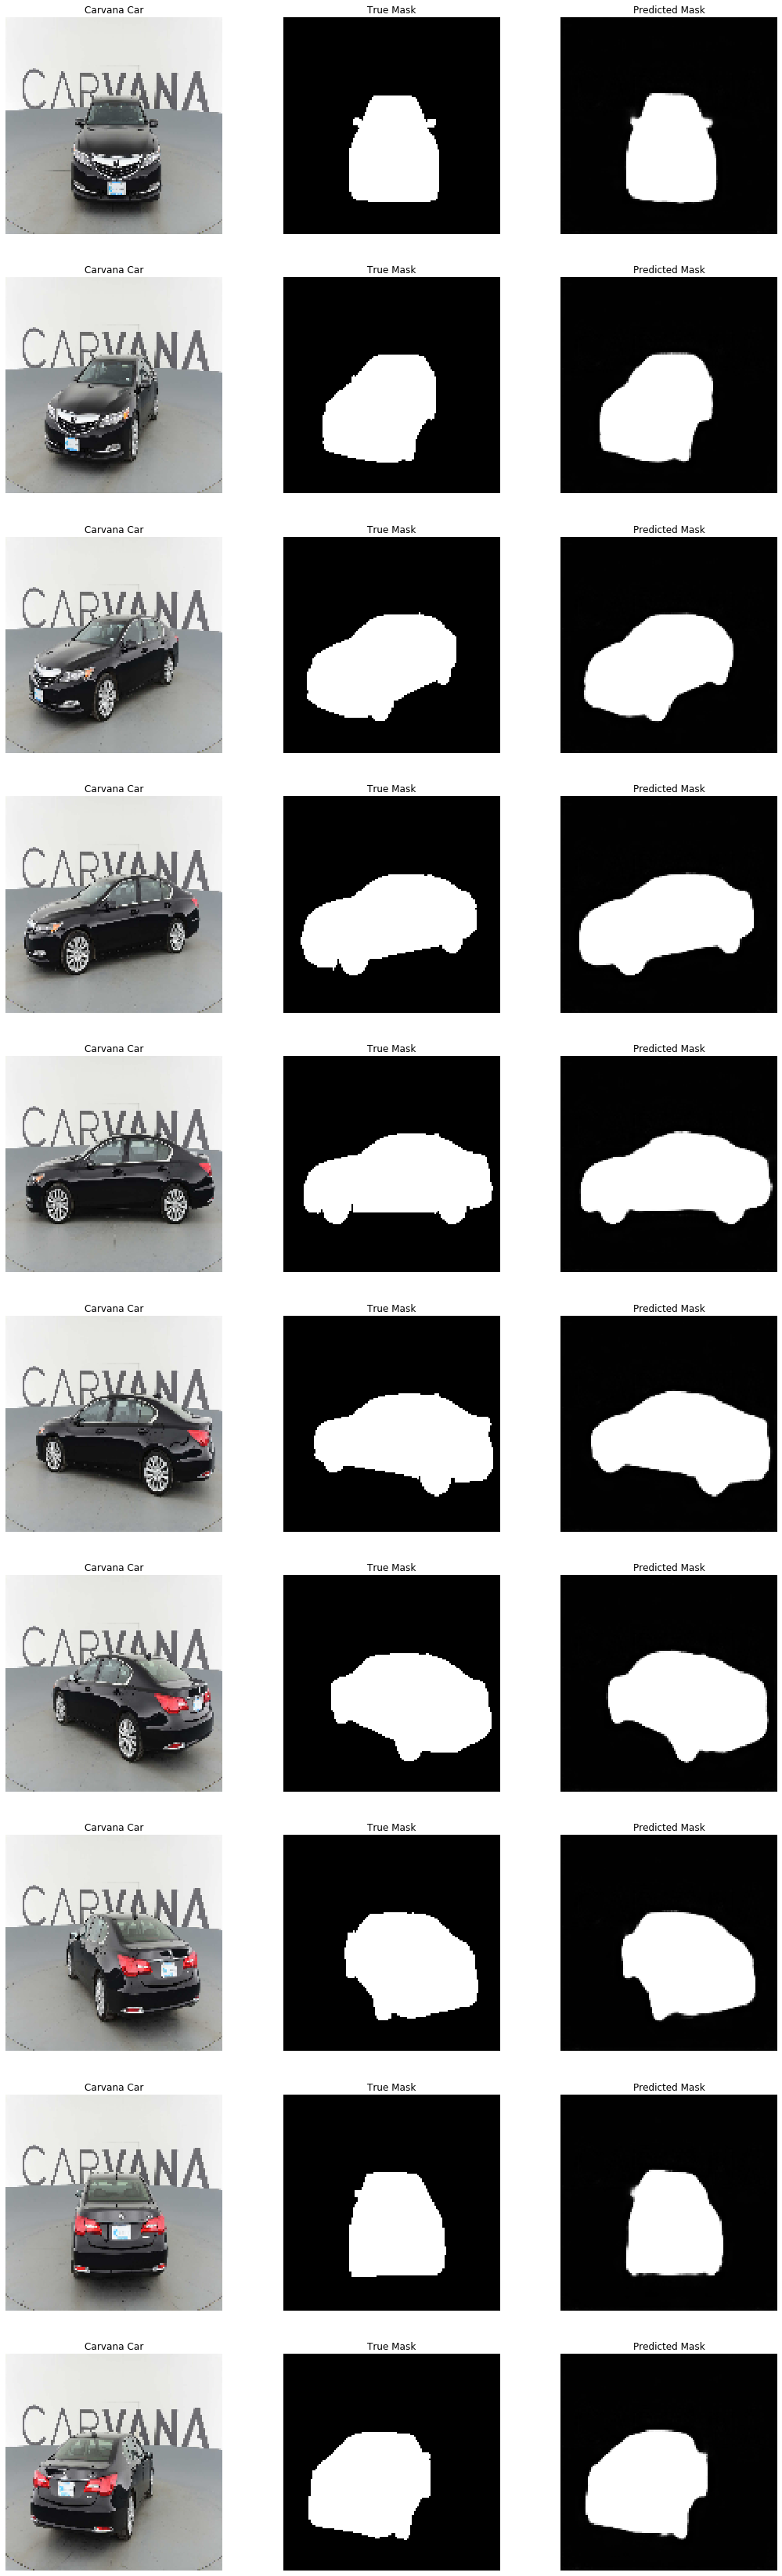

In [44]:
make_inference(test_imgs[:10], test_masks[:10],
               pred_masks[:10], num_samples=10)

In [45]:
checkpoint_dir = os.path.join(PROJ_ROOT, 'checkpoint')
tf.keras.models.save_model(unet, checkpoint_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../checkpoint/assets


In [ ]:
# architectures:
# try LinkNet: encoder - try Resnet 34 (pretrained on Imagenet)
# decoder has 3 blocks: conv 1x1 w/ n//4filters - convTrans 3x3, stride 2, 
# n//filters, conv 1x1 to match number of filters w/ input size
# encode & decoder layers /w matching f.m are connected thru plus operation
# also try concat them in filters dim & use conv 1x1 (to decrease number of
# filters in next layers) instead of plus in LinkNet skip connections

# try soft augmentations: horiz filps, 100 pix shifts, 10% scaling, 
# 5 degree rotations, and HSV augmentations
# test augmentation: horiz flips

# lr: Adam(1e-4 for first 12 epochs & 1e-5 for 6 more epochs)
# lr: at end, 3 cycles of (2 epcoch 1e-4, 2 epoch 1e-5, 1 epoch 1e-6)

# loss func: 1 + BCE - Dice (BCE /pixel bce loss)

# could try bagging: maybe 6 diff neworks, 5 folds each, avg pred's

In [ ]:
# Unet encoder based on VGG-11 (pretrained weights)
# augmentation: horiz flips, color augs, transforming car to grayscale
# orig imgs (1918, 1280) pad to (1920, 1280) so each side divisible by 
# 32 (ntwrk req), then use as input
# w/ this architecture and img size, can't use deep encoders, batch size
# needs to be small
# dont train on crops & pred full imgs; segmentation works better when 
# object smaller than input image
# loss func: BCE - ln(DICE) -> simplifies thresholding, push pred's to
# ends of [0, 1] interval

# lr: first 30 epochs, decrease lr by factor of 2 when val loss doesn't improve for 2 epochs
# next 20, try cyclic lr: oscillate on schedule: 1e-6, 1e-5, 1e-4, 1e-5, 1e-6 w/ 2 epochs in
# each cycle

In [ ]:
train_img_paths = sorted(glob('../dataset/train/*.jpg'))
train_mask_paths = sorted(glob('../dataset/train_masks/*.gif'))

train_imgs = tf.data.Dataset.list_files(train_img_paths, shuffle=False)
train_masks = tf.data.Dataset.list_files(train_mask_paths, shuffle=False)